In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays

using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [60]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= 0.07; k2 = 0.07
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [61]:
k_space = range(0.0, 1.0, step = 0.0002)


spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)
length(k_space)

5001

In [62]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
  0.07
  0.07
  0.0

In [63]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]
    println("p: $p"); flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: 0.0
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0]
Spectrum: [0.01475262720375142, 0.007389229099361945, 0.00013136450101620072, -0.0016274065742748773, -7.133424376505271, -10.183870695556994]
Last point: [-1.262547616311424, -7.111367836284166, 3.6704824121018835, -1.002035197498644, -4.245278790420553, 3.747735025647847]
x_sum before truncate length: 3680739
x_sum after truncate length: 1840371
counts: 189
>>>>>>>>>>>>>>>

Initial condition: [-1.262547616311424, -7.111367836284166, 3.6704824121018835, -1.002035197498644, -4.245278790420553, 3.747735025647847]
index: 2
k: 0.0002
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0002]
Spectrum: [0.015001880879801236, 0.007467977121875158, 1.6637014464579647e-5, -0.002226541035988917, -7.1295742930980515, -10.192068338898427]
Last point: [-0.6790131210904019, -1.635431072974616, 4.004221764313548, -0.937814725702815, -3.2962763107521167,

Last point: [-0.9640940696048735, -3.6163196013925143, 4.076348343271809, -0.6180843626269443, -1.4882672239776373, 3.784232150125749]
x_sum before truncate length: 3692963
x_sum after truncate length: 1846483
counts: 120
>>>>>>>>>>>>>>>

Initial condition: [-0.9640940696048735, -3.6163196013925143, 4.076348343271809, -0.6180843626269443, -1.4882672239776373, 3.784232150125749]
index: 15
k: 0.0028
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0028]
Spectrum: [0.015207981279051888, 0.007624968686547891, 0.00016591898185598232, -0.001343900223233892, -7.109737963049119, -10.217457115562835]
Last point: [-0.7497629109385278, -2.2182344115749943, 3.8281650788597936, -0.751795827503462, -2.0697106972780026, 4.014371951077449]
x_sum before truncate length: 3683088
x_sum after truncate length: 1841545
counts: 159
>>>>>>>>>>>>>>>

Initial condition: [-0.7497629109385278, -2.2182344115749943, 3.8281650788597936, -0.751795827503462, -2.0697106972780026, 4.014371951077449]
inde

index: 28
k: 0.0054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0054]
Spectrum: [0.015757893950969274, 0.008124615955289618, 0.00013755526588287716, -0.000949215409097811, -7.079644167819066, -10.242163066805391]
Last point: [-0.9268082860077131, -3.3605059153276504, 4.005173039459801, -0.8163611382660759, -2.4582487644806927, 4.066777794233077]
x_sum before truncate length: 3694743
x_sum after truncate length: 1847373
counts: 84
>>>>>>>>>>>>>>>

Initial condition: [-0.9268082860077131, -3.3605059153276504, 4.005173039459801, -0.8163611382660759, -2.4582487644806927, 4.066777794233077]
index: 29
k: 0.0056
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0056]
Spectrum: [0.015513404433029709, 0.007705344312301416, 0.00017152676062304095, -0.0015055205192825657, -7.092650629059855, -10.240046250403074]
Last point: [-0.7790196133050714, -2.2255311108289946, 4.03899318892314, -0.898281698686038, -3.2929962058035844, 3.8214716339378]
x_sum before truncat

x_sum before truncate length: 3688703
x_sum after truncate length: 1844353
counts: 86
>>>>>>>>>>>>>>>

Initial condition: [-0.9398714418710309, -3.388943447703024, 4.094707264758856, -0.8797511844166105, -2.829254331201696, 4.177834569508031]
index: 42
k: 0.0082
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0082]
Spectrum: [0.016264125443573238, 0.008413427124827332, 0.0002749132920451509, -0.0010756397438719237, -7.101571391303972, -10.22330789271075]
Last point: [-1.1450791152946056, -5.463130465193505, 3.9811820534414077, -0.9197598163353351, -3.0234441677200246, 4.315002115387595]
x_sum before truncate length: 3694409
x_sum after truncate length: 1847206
counts: 140
>>>>>>>>>>>>>>>

Initial condition: [-1.1450791152946056, -5.463130465193505, 3.9811820534414077, -0.9197598163353351, -3.0234441677200246, 4.315002115387595]
index: 43
k: 0.0084
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0084]
Spectrum: [0.016037893554272337, 0.00834098891386108

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0108]
Spectrum: [0.01677265946396311, 0.008676786858463433, 0.00013107416047988718, -0.0008888422150536875, -7.087359342969492, -10.24048628854798]
Last point: [-1.1753364641890025, -6.030495308292822, 3.72495135905606, -1.1924730957743574, -6.020783772244285, 3.947322779222816]
x_sum before truncate length: 3681749
x_sum after truncate length: 1840876
counts: 81
>>>>>>>>>>>>>>>

Initial condition: [-1.1753364641890025, -6.030495308292822, 3.72495135905606, -1.1924730957743574, -6.020783772244285, 3.947322779222816]
index: 56
k: 0.011
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.011]
Spectrum: [0.01691542177574619, 0.009035251740868028, 0.00027814363971074185, -0.0006138894981990682, -7.102083407925378, -10.220125947318383]
Last point: [-0.9199077424490726, -3.4449203050234365, 3.8458762131151674, -0.9266274933478998, -3.374081575610088, 3.987315480301615]
x_sum before truncate length: 3681854
x_sum af

x_sum before truncate length: 3689366
x_sum after truncate length: 1844684
counts: 59
>>>>>>>>>>>>>>>

Initial condition: [0.13885073406918663, 0.7100538489704153, 4.233716442202358, -0.741507312484574, -2.2517805486617353, 3.922598399571665]
index: 69
k: 0.0136
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0136]
Spectrum: [0.01695792153066892, 0.008550269475936054, 0.0002656562092513488, -0.0007333284188245189, -7.073973611140468, -10.261464916596982]
Last point: [-0.8114387295165854, -2.518953959297643, 3.9552305036829924, -1.0508067795951124, -4.594973858969482, 3.873207846836527]
x_sum before truncate length: 3682408
x_sum after truncate length: 1841205
counts: 65
>>>>>>>>>>>>>>>

Initial condition: [-0.8114387295165854, -2.518953959297643, 3.9552305036829924, -1.0508067795951124, -4.594973858969482, 3.873207846836527]
index: 70
k: 0.0138
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0138]
Spectrum: [0.016720452105479355, 0.009103348145328205, 

k: 0.0162
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0162]
Spectrum: [0.01734781284648062, 0.009108220767326891, 0.0003283702727930576, -0.00046717965502676294, -7.060008128233077, -10.265227222480084]
Last point: [-1.2544694687729094, -6.7218715892481, 3.98422052943314, -1.2187666751592445, -6.185039376067976, 4.099725731518594]
x_sum before truncate length: 3686668
x_sum after truncate length: 1843335
counts: 126
>>>>>>>>>>>>>>>

Initial condition: [-1.2544694687729094, -6.7218715892481, 3.98422052943314, -1.2187666751592445, -6.185039376067976, 4.099725731518594]
index: 83
k: 0.0164
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0164]
Spectrum: [0.017300189922583947, 0.009250022003194558, 0.0004921657423520988, -0.0004429861686755722, -7.049699151515236, -10.273635576629454]
Last point: [-0.7426563089040202, -2.129224571214663, 4.106461615351933, 1.570588406056477, -3.8006938753753765, 4.16552115453174]
x_sum before truncate length: 3684241
x_

x_sum before truncate length: 3693672
x_sum after truncate length: 1846837
counts: 127
>>>>>>>>>>>>>>>

Initial condition: [-0.9161508840710204, -3.103355092611356, 4.19936137928514, -0.7261784881271668, -1.915794527553788, 4.0013060431822]
index: 96
k: 0.019
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.019]
Spectrum: [0.017625491494451775, 0.009281995597735543, 0.0007734699394344816, -0.00027015045811269175, -7.043332467828602, -10.2831707035944]
Last point: [-1.2148780435449988, -6.448860734966728, 3.768949495695425, -0.9972146742127118, -3.896223535362979, 4.081932488567695]
x_sum before truncate length: 3687313
x_sum after truncate length: 1843658
counts: 75
>>>>>>>>>>>>>>>

Initial condition: [-1.2148780435449988, -6.448860734966728, 3.768949495695425, -0.9972146742127118, -3.896223535362979, 4.081932488567695]
index: 97
k: 0.0192
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0192]
Spectrum: [0.017954329587015618, 0.009815643275168739, 0.0003

k: 0.0216
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0216]
Spectrum: [0.018191354473533386, 0.009521237511674652, 0.0005462542115458934, -0.0006650170201090316, -7.021252340931076, -10.304672911987023]
Last point: [-0.854209261296714, -2.904724442046144, 4.108748240343274, 0.9556698457644625, -0.11156232532899503, 4.204019722254543]
x_sum before truncate length: 3690252
x_sum after truncate length: 1845127
counts: 82
>>>>>>>>>>>>>>>

Initial condition: [-0.854209261296714, -2.904724442046144, 4.108748240343274, 0.9556698457644625, -0.11156232532899503, 4.204019722254543]
index: 110
k: 0.0218
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0218]
Spectrum: [0.018171050972477808, 0.009400941597447362, 0.0003322898231334862, -0.00039676823944121445, -7.042117454070822, -10.293789504890585]
Last point: [-0.919555872733751, -3.3845647682486923, 3.911799778688057, -0.8625850305631723, -2.7518213985569586, 4.116426998271211]
x_sum before truncate length: 

x_sum before truncate length: 3697247
x_sum after truncate length: 1848625
counts: 70
>>>>>>>>>>>>>>>

Initial condition: [-0.9280262812661464, -3.192729183815175, 4.221268331298348, -0.5457406443833521, -0.9243367434920151, 4.029412856726213]
index: 123
k: 0.0244
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0244]
Spectrum: [0.018632794254997937, 0.00940222909174938, 0.000680261448320181, -0.00021468184642115158, -7.020972601426732, -10.312511105341187]
Last point: [-0.8518284882632161, -2.728319649306953, 4.2690483787350635, 0.15756421211142868, 0.7210274132481701, 4.241092390530629]
x_sum before truncate length: 3698352
x_sum after truncate length: 1849177
counts: 68
>>>>>>>>>>>>>>>

Initial condition: [-0.8518284882632161, -2.728319649306953, 4.2690483787350635, 0.15756421211142868, 0.7210274132481701, 4.241092390530629]
index: 124
k: 0.0246
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0246]
Spectrum: [0.018495238876752113, 0.00979552957367488

index: 136
k: 0.027
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.027]
Spectrum: [0.018640385156761478, 0.009964778415248496, 0.00044557600030257556, -0.00039936831275565345, -7.014357297965408, -10.323710238265496]
Last point: [-1.048467584950113, -4.285895341405173, 4.191030812411514, -0.8392760179386689, -2.897832583636036, 3.7501013616842855]
x_sum before truncate length: 3711030
x_sum after truncate length: 1855516
counts: 75
>>>>>>>>>>>>>>>

Initial condition: [-1.048467584950113, -4.285895341405173, 4.191030812411514, -0.8392760179386689, -2.897832583636036, 3.7501013616842855]
index: 137
k: 0.0272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0272]
Spectrum: [0.018462956574062384, 0.009758375419914901, 0.0006537650077481529, -0.0006361002545666306, -7.010004317592114, -10.329426161590337]
Last point: [-0.8959490670628784, -2.914493738416704, 4.231161839026323, -0.7126611007481108, -2.025306657983181, 3.7770630379235928]
x_sum before truncat

x_sum before truncate length: 3712640
x_sum after truncate length: 1856321
counts: 57
>>>>>>>>>>>>>>>

Initial condition: [-0.8242001520371777, -2.5490139532031177, 4.021157640489394, -1.0386368266778723, -4.277868445208007, 4.096734330917502]
index: 150
k: 0.0298
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0298]
Spectrum: [0.018622992659853076, 0.009892332842090026, 0.0005051403449053932, -0.0005514912953766499, -6.998228284603699, -10.352334658161842]
Last point: [-1.1475139413539162, -5.485219422039219, 4.009322997096216, -0.5626751917199148, -1.1847686785492417, 3.8016316491964974]
x_sum before truncate length: 3715794
x_sum after truncate length: 1857898
counts: 46
>>>>>>>>>>>>>>>

Initial condition: [-1.1475139413539162, -5.485219422039219, 4.009322997096216, -0.5626751917199148, -1.1847686785492417, 3.8016316491964974]
index: 151
k: 0.03
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.03]
Spectrum: [0.018936244373947354, 0.009698711259871484

index: 163
k: 0.0324
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0324]
Spectrum: [0.01871961796703296, 0.009393995350339784, 0.0003119963898675435, -0.0008064732314260141, -7.011067113988801, -10.36505996565883]
Last point: [-0.5083482743893567, -4.079068525632712, 3.9982712199196206, -0.9179718206437073, -3.4773134835758146, 3.95009531105247]
x_sum before truncate length: 3724174
x_sum after truncate length: 1862088
counts: 26
>>>>>>>>>>>>>>>

Initial condition: [-0.5083482743893567, -4.079068525632712, 3.9982712199196206, -0.9179718206437073, -3.4773134835758146, 3.95009531105247]
index: 164
k: 0.0326
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0326]
Spectrum: [0.018873454828923004, 0.00957144030017062, 0.0004070759283642157, -0.0005925930215518277, -7.0060927243236675, -10.36356937380676]
Last point: [1.2226022120131153, -0.8283294648651159, 4.1238049115379205, -0.8639519940131747, -2.880091290558552, 4.2465632882156825]
x_sum before truncat

x_sum before truncate length: 3735675
x_sum after truncate length: 1867839
counts: 9
>>>>>>>>>>>>>>>

Initial condition: [1.5936983658982131, -5.954217473386123, 3.634854744455686, -0.8548792327790332, -2.9621208699150596, 4.224130116248104]
index: 177
k: 0.0352
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0352]
Spectrum: [0.018532804470679523, 0.009322904928246724, 0.0002022254157103961, -0.0011827837531721973, -7.01829200245831, -10.386109468098123]
Last point: [-1.134313819098117, -5.11357947344742, 4.3224665096980806, -0.3344780751062102, 0.009366546398707945, 4.21026630366684]
x_sum before truncate length: 3731649
x_sum after truncate length: 1865826
counts: 18
>>>>>>>>>>>>>>>

Initial condition: [-1.134313819098117, -5.11357947344742, 4.3224665096980806, -0.3344780751062102, 0.009366546398707945, 4.21026630366684]
index: 178
k: 0.0354
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0354]
Spectrum: [0.018936256140335134, 0.009575149715673664, 0

Spectrum: [0.018972485530189466, 0.008749728202474672, 4.79916497744527e-5, -0.001781208789896418, -7.036576838249355, -10.381773782943334]
Last point: [-0.9326762178476572, -3.1117732023786204, 4.326034374095617, -1.2177999446531045, -6.106256646078332, 4.184416923989572]
x_sum before truncate length: 3737410
x_sum after truncate length: 1868706
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9326762178476572, -3.1117732023786204, 4.326034374095617, -1.2177999446531045, -6.106256646078332, 4.184416923989572]
index: 191
k: 0.038
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.038]
Spectrum: [0.01877933218993401, 0.008798753253257323, 0.00010031508700410277, -0.0014101695082671122, -7.032640789201216, -10.384578077301954]
Last point: [-0.8413867963315381, -2.6632496449949783, 4.04163782977303, -0.792875247096787, -2.396738620095948, 3.94952251045261]
x_sum before truncate length: 3737958
x_sum after truncate length: 1868980
counts: 0
>>>>>>>>>>>>>>>

Initial condition

x_sum after truncate length: 1873354
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.742962430282957, -1.878196941267125, 4.163651414203175, -0.8909976745302923, -3.1207723470917514, 3.9559352066926454]
index: 204
k: 0.0406
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0406]
Spectrum: [0.01848408627823873, 0.008789697030213282, 3.051363799640414e-5, -0.002178311251616558, -7.081743980543132, -10.37309869782352]
Last point: [0.7697835755947242, -4.208960028429419, 4.269862295689475, -0.8228054441439844, -2.5145821670749857, 4.328929925485637]
x_sum before truncate length: 3740323
x_sum after truncate length: 1870163
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [0.7697835755947242, -4.208960028429419, 4.269862295689475, -0.8228054441439844, -2.5145821670749857, 4.328929925485637]
index: 205
k: 0.0408
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0408]
Spectrum: [0.017900838772830236, 0.008769328568293188, 7.57455476477885e-6, -0.003048706554172949

Spectrum: [0.017866760520551275, 0.007991677411656685, 9.32130389051952e-6, -0.0036742743932017524, -7.061284682117901, -10.42519302380291]
Last point: [-0.8800095783879148, -2.7100648832411167, 4.298071188322624, -1.2658014739397163, -7.1532428105686074, 3.68592481529329]
x_sum before truncate length: 3771356
x_sum after truncate length: 1885679
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8800095783879148, -2.7100648832411167, 4.298071188322624, -1.2658014739397163, -7.1532428105686074, 3.68592481529329]
index: 218
k: 0.0434
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0434]
Spectrum: [0.017886573564064246, 0.007865046545452389, 3.2353371715651545e-5, -0.0038486200783477806, -7.03726507516657, -10.45247922094597]
Last point: [-1.0570349468106406, -4.2378301692711196, 4.330241644233492, -1.041292365371577, -4.172185777958907, 4.233893426130902]
x_sum before truncate length: 3761842
x_sum after truncate length: 1880922
counts: 0
>>>>>>>>>>>>>>>

Initial conditi

x_sum before truncate length: 3791010
x_sum after truncate length: 1895506
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1761947196165485, -5.7579447958433585, 4.03128745999867, -1.1954009114522104, -5.9906729264404195, 4.0172226544242]
index: 231
k: 0.046
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.046]
Spectrum: [0.016330587566126525, 0.006888954078783002, 4.967389796679749e-6, -0.0050360857900493975, -7.051926262862737, -10.498844102096712]
Last point: [-0.7924509241889516, -2.3688535201798357, 3.973017818450859, -0.9408895512935543, -3.239427646664972, 4.278011947327371]
x_sum before truncate length: 3794825
x_sum after truncate length: 1897414
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7924509241889516, -2.3688535201798357, 3.973017818450859, -0.9408895512935543, -3.239427646664972, 4.278011947327371]
index: 232
k: 0.0462
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0462]
Spectrum: [0.016413127641406473, 0.006894133935629192, -1.

Spectrum: [0.00016450824122258984, -0.0005819472089064535, -0.001181546800525325, -0.017961119240997792, -7.058821150879432, -10.83747013238458]
Last point: [-0.8329771541988766, -2.28205588509817, 4.391102364187763, -1.0934149329673588, -4.64151818721465, 4.297139333021466]
x_sum before truncate length: 3992949
x_sum after truncate length: 1996476
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8329771541988766, -2.28205588509817, 4.391102364187763, -1.0934149329673588, -4.64151818721465, 4.297139333021466]
index: 245
k: 0.0488
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0488]
Spectrum: [0.002394013691663476, 3.821198004864999e-6, -0.001679192801816262, -0.016752539012414972, -7.045334871290777, -10.849943728469713]
Last point: [-0.5451321456248431, -1.164203773512479, 3.7331046747483656, -0.8100994183481991, -2.5595881104263505, 3.9220500198713832]
x_sum before truncate length: 3997514
x_sum after truncate length: 1998758
counts: 0
>>>>>>>>>>>>>>>

Initial cond

x_sum before truncate length: 4008357
x_sum after truncate length: 2004180
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4227165270721145, -9.111417748638248, 3.8460773740296705, -1.2920774934162162, -7.539314072063643, 3.603010203313765]
index: 258
k: 0.0514
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0514]
Spectrum: [7.337349804564787e-6, -0.008066081974029292, -0.008080806184627554, -0.01860946711042491, -7.099395383914375, -10.824434566384262]
Last point: [-0.7467002690984338, -1.9241748833526284, 4.140145314466471, -0.8310309620351187, -2.252976261036044, 4.42536759934162]
x_sum before truncate length: 4013663
x_sum after truncate length: 2006833
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7467002690984338, -1.9241748833526284, 4.140145314466471, -0.8310309620351187, -2.252976261036044, 4.42536759934162]
index: 259
k: 0.0516
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0516]
Spectrum: [1.2421057447079308e-5, -0.0039183901035206, -

Spectrum: [0.01615770179234644, 0.006131925441729406, 5.221346714352025e-6, -0.008411284726083672, -7.439631654673036, -10.193106463392285]
Last point: [-0.8252557357273854, -2.3473077525254014, 4.263394094070068, -0.8736147882876271, -2.6378930470301074, 4.344119401389427]
x_sum before truncate length: 3742327
x_sum after truncate length: 1871165
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8252557357273854, -2.3473077525254014, 4.263394094070068, -0.8736147882876271, -2.6378930470301074, 4.344119401389427]
index: 272
k: 0.0542
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0542]
Spectrum: [0.016178653381877916, 0.006421037361355061, -1.3578289155638743e-5, -0.007950868147853826, -7.440911151356348, -10.184719992183485]
Last point: [-0.667785888484554, -1.6473092043212643, 3.9524859554697795, -0.4178131572570994, -0.5115053202474912, 3.8998458810467187]
x_sum before truncate length: 3732545
x_sum after truncate length: 1866274
counts: 0
>>>>>>>>>>>>>>>

Initial 

x_sum before truncate length: 3729486
x_sum after truncate length: 1864744
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8390917228769339, -2.683010248614114, 3.994597847592187, -0.8977974910541092, -3.1188262565662384, 4.015040293956852]
index: 285
k: 0.0568
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0568]
Spectrum: [0.01706173883635609, 0.0067870566025836744, 9.075640806652518e-6, -0.0074219039198929835, -7.44401234096324, -10.171331731722594]
Last point: [-0.8256496202311893, -2.351337484870181, 4.422438517156356, -0.17192581326070092, 0.3770178638035689, 4.1894981472501245]
x_sum before truncate length: 3736534
x_sum after truncate length: 1868268
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8256496202311893, -2.351337484870181, 4.422438517156356, -0.17192581326070092, 0.3770178638035689, 4.1894981472501245]
index: 286
k: 0.057
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.057]
Spectrum: [0.016811183613633564, 0.006369206816587759, 

Spectrum: [0.016675485650722768, 0.00638043384616851, -5.03356940017874e-6, -0.007546457717509633, -7.4602058853538615, -10.178720847620585]
Last point: [-0.9023951675735085, -3.1850531362585617, 3.9981591001710033, -0.6582538492122457, -1.5375101192551965, 3.968858399566421]
x_sum before truncate length: 3738878
x_sum after truncate length: 1869440
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9023951675735085, -3.1850531362585617, 3.9981591001710033, -0.6582538492122457, -1.5375101192551965, 3.968858399566421]
index: 299
k: 0.0596
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0596]
Spectrum: [0.017007410609369528, 0.006573387751396758, 3.945398058848666e-6, -0.0073014962615672654, -7.4534377780565855, -10.180983035936228]
Last point: [-0.7783784151557857, -2.502180034021096, 3.7642930610276615, -0.8139885507501277, -3.467480342421319, 3.9525893157682943]
x_sum before truncate length: 3736372
x_sum after truncate length: 1868187
counts: 0
>>>>>>>>>>>>>>>

Initia

x_sum before truncate length: 3734768
x_sum after truncate length: 1867385
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.2707977358975528, -6.755274985559768, 4.164353822357131, -1.2897143764551264, -6.962748555237575, 4.199697229818786]
index: 312
k: 0.0622
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0622]
Spectrum: [0.017610910858263558, 0.006840272246040907, -1.1140593888695972e-6, -0.007324673915703518, -7.476896091451182, -10.14662574077238]
Last point: [-0.6359642103178103, -1.247537985325787, 4.1677176872564266, -0.8707964912047141, -2.7488320620580238, 4.209523244139674]
x_sum before truncate length: 3730455
x_sum after truncate length: 1865229
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6359642103178103, -1.247537985325787, 4.1677176872564266, -0.8707964912047141, -2.7488320620580238, 4.209523244139674]
index: 313
k: 0.0624
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0624]
Spectrum: [0.01763727807318668, 0.006627517674240737,

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0648]
Spectrum: [0.017652434617191445, 0.006880592666932504, 2.119913062640317e-7, -0.007046772774990439, -7.49285425783501, -10.138907119579859]
Last point: [-0.599254032676305, -1.7475692248725483, 3.4250548631672406, -0.3183841380803566, -0.48842425664580913, 3.5127209933753725]
x_sum before truncate length: 3727375
x_sum after truncate length: 1863689
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.599254032676305, -1.7475692248725483, 3.4250548631672406, -0.3183841380803566, -0.48842425664580913, 3.5127209933753725]
index: 326
k: 0.065
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.065]
Spectrum: [0.017331660335442357, 0.006663278734182036, -7.502807614943013e-6, -0.007268030264775609, -7.495621347569296, -10.143346791383339]
Last point: [-1.263077463147984, -6.716187364878012, 4.105678911747392, -1.2410240589114208, -6.479262986948586, 4.067702612424244]
x_sum before truncate length: 3726124
x_su

x_sum before truncate length: 3709119
x_sum after truncate length: 1854561
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.845799517991399, -2.465670764980145, 4.319071434564196, -0.621519105759076, -1.211454085641992, 4.120677307596433]
index: 339
k: 0.0676
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0676]
Spectrum: [0.017561931018987762, 0.0066665384088981615, -9.415722381292564e-6, -0.006774537739248212, -7.534544491525414, -10.11284463622337]
Last point: [-0.9553030868929269, -3.4703361103806523, 4.152427824710087, -0.909103149450903, -3.1802064894898434, 4.041135754612113]
x_sum before truncate length: 3714992
x_sum after truncate length: 1857497
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9553030868929269, -3.4703361103806523, 4.152427824710087, -0.909103149450903, -3.1802064894898434, 4.041135754612113]
index: 340
k: 0.0678
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0678]
Spectrum: [0.01764853799882783, 0.006713640648077359, 1.1

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0702]
Spectrum: [0.017859766379032724, 0.006977773297637936, -4.9074582516071755e-6, -0.006080482202676636, -7.5767362793661315, -10.059232928273655]
Last point: [-0.8486237168397356, -2.627328963131856, 4.1384059205140815, -0.8812679929271685, -2.843398783865362, 4.178117952309937]
x_sum before truncate length: 3710158
x_sum after truncate length: 1855080
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8486237168397356, -2.627328963131856, 4.1384059205140815, -0.8812679929271685, -2.843398783865362, 4.178117952309937]
index: 353
k: 0.0704
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0704]
Spectrum: [0.01730602806251122, 0.007071730981306725, -3.3213409824251933e-6, -0.0066307073552894545, -7.537639736771822, -10.110549194543102]
Last point: [-0.8004080981033322, -2.4379857681808406, 3.9631342269125116, -0.8081491046844963, -2.44956836769002, 4.012427050096526]
x_sum before truncate length: 3705467
x

x_sum before truncate length: 3704986
x_sum after truncate length: 1852494
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.756366827074566, -2.39014466357906, 3.7081205417403624, -0.5108861915845869, -0.7061337680901528, 4.101144090573724]
index: 366
k: 0.073
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.073]
Spectrum: [0.017943850887725765, 0.006791144841616407, 1.5881753947273228e-6, -0.006148832950528909, -7.5897656016205275, -10.06446905041298]
Last point: [-0.7407291070181438, -2.1381165682474563, 3.8639100018335752, -0.6341674830638985, -1.4875866572485756, 3.879916432003938]
x_sum before truncate length: 3709639
x_sum after truncate length: 1854821
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7407291070181438, -2.1381165682474563, 3.8639100018335752, -0.6341674830638985, -1.4875866572485756, 3.879916432003938]
index: 367
k: 0.0732
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0732]
Spectrum: [0.01723423203152816, 0.006725812326426141,

Spectrum: [0.017167917985170898, 0.005815334139911214, 4.3991290551744367e-7, -0.00733884957032428, -7.664733538122685, -10.01949686391619]
Last point: [-0.7479661847195208, -2.1374317781088195, 4.220993955748264, 0.9966401732399719, -0.3924633539150477, 4.377501065610515]
x_sum before truncate length: 3708442
x_sum after truncate length: 1854222
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7479661847195208, -2.1374317781088195, 4.220993955748264, 0.9966401732399719, -0.3924633539150477, 4.377501065610515]
index: 380
k: 0.0758
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0758]
Spectrum: [0.017094183498526316, 0.005806420236494533, -3.276064188803367e-6, -0.007418713434799595, -7.657026799679437, -10.036620492002244]
Last point: [-0.8328707476526186, -2.4305521165284163, 4.233356769562656, -0.8376874210342972, -2.318303778425311, 4.400996908187608]
x_sum before truncate length: 3699276
x_sum after truncate length: 1849639
counts: 0
>>>>>>>>>>>>>>>

Initial condi

x_sum before truncate length: 3714150
x_sum after truncate length: 1857076
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1848234111434564, -6.050976910239293, 4.1411261262222325, -0.009325123972807551, -1.4783554766072362, 4.587426486369829]
index: 393
k: 0.0784
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0784]
Spectrum: [0.016427698990163088, 0.004803093721311797, -1.2969465551284896e-6, -0.007311943234747352, -7.690081948452505, -10.027778654940839]
Last point: [-0.9894330507745939, -4.386924189060783, 3.4712985326349455, -0.8952687791564373, -3.6044803637602993, 3.435897211567961]
x_sum before truncate length: 3713949
x_sum after truncate length: 1856976
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9894330507745939, -4.386924189060783, 3.4712985326349455, -0.8952687791564373, -3.6044803637602993, 3.435897211567961]
index: 394
k: 0.0786
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0786]
Spectrum: [0.01611517470523006, 0.00501237431003

index: 406
k: 0.081
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.081]
Spectrum: [0.01612101762077671, 0.004506796167561084, 8.822716909104387e-6, -0.00814484242438027, -7.72915978551725, -10.009255024166803]
Last point: [-1.4643403643992141, -9.518296921193565, 4.080065152547562, -1.289145056185715, -7.081572175331389, 4.0484248524202355]
x_sum before truncate length: 3718281
x_sum after truncate length: 1859142
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4643403643992141, -9.518296921193565, 4.080065152547562, -1.289145056185715, -7.081572175331389, 4.0484248524202355]
index: 407
k: 0.0812
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0812]
Spectrum: [0.01566456885785588, 0.004051793029193068, -5.13905895439327e-6, -0.008627445847888599, -7.737131215821437, -10.012901879792844]
Last point: [0.4451325268560233, 0.6828728963276876, 4.388502501322026, -0.5038507897003774, -0.8498533561054001, 4.150441296909131]
x_sum before truncate length: 37

x_sum before truncate length: 3704162
x_sum after truncate length: 1852082
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9416220601205205, -3.3481851202382478, 4.162724643354967, -0.863692289684204, -2.7298516521696916, 4.145556970804973]
index: 420
k: 0.0838
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0838]
Spectrum: [0.014283752602606982, 0.0029281832131568433, 1.745543671555179e-5, -0.011065736827553121, -7.83244743963824, -9.952009523060946]
Last point: [-0.5746041681716442, -1.5843242182227855, 3.4221674365882184, -0.518630970847697, -1.3230836301291546, 3.4084835480809286]
x_sum before truncate length: 3711299
x_sum after truncate length: 1855651
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.5746041681716442, -1.5843242182227855, 3.4221674365882184, -0.518630970847697, -1.3230836301291546, 3.4084835480809286]
index: 421
k: 0.084
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.084]
Spectrum: [0.014306403687301829, 0.003140363090730928,

k: 0.0864
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0864]
Spectrum: [1.0646178320964844e-5, -0.005375112708574172, -0.012522101381470944, -0.020496023312414697, -8.082035397864491, -9.823807271222295]
Last point: [-0.9776184860535007, -3.7780141523709183, 4.03096290228982, -0.8846181260864558, -3.025007972531088, 3.9922763363651375]
x_sum before truncate length: 3709482
x_sum after truncate length: 1854742
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9776184860535007, -3.7780141523709183, 4.03096290228982, -0.8846181260864558, -3.025007972531088, 3.9922763363651375]
index: 434
k: 0.0866
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0866]
Spectrum: [-2.3156764427379635e-6, -0.005318877573006921, -0.013749507310947453, -0.018076063733581917, -8.080469105566253, -9.825916308350651]
Last point: [-0.8597306997072792, -2.451788044110693, 4.437586845474476, -0.8144699767676464, -2.0301265634370553, 4.537018700929377]
x_sum before truncate length:

x_sum before truncate length: 3706269
x_sum after truncate length: 1853136
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.3552939443426457, -8.40364513399675, 3.573555461210345, -1.411629144444957, -9.186248356342228, 3.5926595493746922]
index: 447
k: 0.0892
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0892]
Spectrum: [9.706897061962722e-6, -0.003253416618307207, -0.015028028124242983, -0.015455267636798407, -8.080298103712456, -9.829993007842786]
Last point: [-0.9223032405194961, -2.951080306950832, 4.426124120337122, -0.8736229013335015, -2.4752964942212845, 4.520692604358432]
x_sum before truncate length: 3707046
x_sum after truncate length: 1853524
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9223032405194961, -2.951080306950832, 4.426124120337122, -0.8736229013335015, -2.4752964942212845, 4.520692604358432]
index: 448
k: 0.0894
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0894]
Spectrum: [8.53251565651362e-6, -0.003303193309686259, -

Spectrum: [-3.400984506776067e-6, -0.004555211335955139, -0.007961027497858875, -0.02478111704682335, -8.113718386065848, -9.799959586572804]
Last point: [-0.9555677710265909, -3.596775779515689, 4.019083905371209, -0.8665179481818812, -2.8997477282164743, 3.9761196499462574]
x_sum before truncate length: 3706712
x_sum after truncate length: 1853357
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9555677710265909, -3.596775779515689, 4.019083905371209, -0.8665179481818812, -2.8997477282164743, 3.9761196499462574]
index: 461
k: 0.092
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.092]
Spectrum: [4.042687310468748e-6, -0.004495737597470311, -0.00689702444070162, -0.027748958816025432, -8.113903300496325, -9.798309284604127]
Last point: [-1.3497686226191674, -8.347021315175018, 3.553751405915547, -1.4028609789788675, -9.0736820011019, 3.5781029799130195]
x_sum before truncate length: 3707542
x_sum after truncate length: 1853772
counts: 0
>>>>>>>>>>>>>>>

Initial condit

x_sum before truncate length: 3706016
x_sum after truncate length: 1853009
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [0.4816919086500212, 0.6421539683445202, 4.367451788490971, -0.6931241179876408, -1.5299121453394762, 4.5128944383694565]
index: 474
k: 0.0946
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0946]
Spectrum: [0.014122074911419416, 0.0019939503845925162, 4.689820752791813e-6, -0.010847652405351635, -7.915513550618964, -9.924402044742768]
Last point: [-1.4438717644402588, -9.617167180477749, 3.637802509478196, -1.3876233537451235, -8.834580954696218, 3.5921069867861104]
x_sum before truncate length: 3703781
x_sum after truncate length: 1851892
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4438717644402588, -9.617167180477749, 3.637802509478196, -1.3876233537451235, -8.834580954696218, 3.5921069867861104]
index: 475
k: 0.0948
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0948]
Spectrum: [0.014778855376368898, 0.0027154075453166148,

Spectrum: [0.016381944031389515, 0.0025659114376428292, -2.0020281192450754e-5, -0.009533851749412564, -7.855622201499413, -10.010964373698622]
Last point: [-1.537961984177536, -10.558044174699113, 4.21496113707365, -1.2809799892881533, -7.016056908288879, 3.9968603732878125]
x_sum before truncate length: 3720015
x_sum after truncate length: 1860009
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.537961984177536, -10.558044174699113, 4.21496113707365, -1.2809799892881533, -7.016056908288879, 3.9968603732878125]
index: 488
k: 0.0974
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0974]
Spectrum: [0.016660938992485833, 0.002489243541210952, -5.6630376602979985e-6, -0.008593601555935268, -7.856009939272592, -10.004550091291273]
Last point: [-1.1081773043459244, -5.073985879990891, 3.9867921745200445, -0.999264513126133, -4.009019205865715, 3.971108925767615]
x_sum before truncate length: 3730921
x_sum after truncate length: 1865462
counts: 0
>>>>>>>>>>>>>>>

Initial con

x_sum before truncate length: 3736319
x_sum after truncate length: 1868161
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8911048341349149, -2.918954762778439, 4.174408697385771, -0.9164108193904942, -3.148739209021579, 4.148549392543483]
index: 501
k: 0.1
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1]
Spectrum: [0.016815062493545467, 0.0026363733695472925, 1.6465689907150689e-7, -0.009706593603246032, -7.853491471816764, -10.023330094438903]
Last point: [-1.2737395961191467, -7.071415855125379, 3.8583567175359414, -1.3294737184830239, -7.839729099382372, 3.8163287764130005]
x_sum before truncate length: 3739088
x_sum after truncate length: 1869545
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.2737395961191467, -7.071415855125379, 3.8583567175359414, -1.3294737184830239, -7.839729099382372, 3.8163287764130005]
index: 502
k: 0.1002
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1002]
Spectrum: [0.01689588348301499, 0.002973051443922206, -5.2

Spectrum: [0.01737697217629687, 0.002896058624586877, -6.927939771914615e-6, -0.010165583972709894, -7.768107110073853, -10.108146196561835]
Last point: [-0.7586211154151177, -1.668579188979516, 4.48087792320532, -1.205717507270399, -5.922177331446757, 4.267276444188477]
x_sum before truncate length: 3766655
x_sum after truncate length: 1883329
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7586211154151177, -1.668579188979516, 4.48087792320532, -1.205717507270399, -5.922177331446757, 4.267276444188477]
index: 515
k: 0.1028
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1028]
Spectrum: [0.017815798843442598, 0.0028957139405568796, -8.546063121654778e-6, -0.009602528150957546, -7.764804287913303, -10.105184309043947]
Last point: [-0.6518726142036011, -2.0170930771975475, 3.4421986336605865, -0.35789915294122726, -0.5706717505408971, 3.5518288420773674]
x_sum before truncate length: 3767205
x_sum after truncate length: 1883604
counts: 0
>>>>>>>>>>>>>>>

Initial condi

x_sum before truncate length: 3773563
x_sum after truncate length: 1886783
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.3681131558320125, -7.96328516701939, 4.279861435371887, -0.9821751980871428, -3.733581782333361, 4.0765954877231]
index: 528
k: 0.1054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1054]
Spectrum: [0.0173659844327533, 0.0030790887205590415, -1.71743158168035e-5, -0.010062786861261636, -7.665166165181131, -10.21294020582477]
Last point: [-0.7028054254100242, -2.1464453419699563, 3.7869992536102672, -0.05723642298169045, 0.40492513043191297, 3.9379123700067233]
x_sum before truncate length: 3776544
x_sum after truncate length: 1888273
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7028054254100242, -2.1464453419699563, 3.7869992536102672, -0.05723642298169045, 0.40492513043191297, 3.9379123700067233]
index: 529
k: 0.1056
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1056]
Spectrum: [0.017395012012164306, 0.002532915310421530

index: 541
k: 0.108
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.108]
Spectrum: [0.01709261278327319, 0.0020852777540054115, 2.0738682985924357e-6, -0.010851349988528705, -7.695572267409233, -10.18666035379911]
Last point: [-0.6461560832388706, -1.2128371220853105, 4.273327408052998, -0.7842396484633221, -2.0485002924276854, 4.300719390709979]
x_sum before truncate length: 3793328
x_sum after truncate length: 1896665
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6461560832388706, -1.2128371220853105, 4.273327408052998, -0.7842396484633221, -2.0485002924276854, 4.300719390709979]
index: 542
k: 0.1082
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1082]
Spectrum: [0.01691082906529216, 0.0023901915470409397, -2.2652965166412812e-6, -0.010521100168551263, -7.695185326719283, -10.189968300240118]
Last point: [-0.5937431485730562, -0.7005063792221392, 4.624747206359522, -0.4090495552070843, -0.21851639339456613, 4.231277165350567]
x_sum before trunca

x_sum before truncate length: 3799355
x_sum after truncate length: 1899679
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6490000365431617, -1.2474594929101406, 4.525412055124605, -0.1251798806657545, 0.49729072124079543, 4.2920662056466155]
index: 555
k: 0.1108
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1108]
Spectrum: [0.016967973686019152, 0.0011715360290890234, -9.780214729150812e-5, -0.012967928918718662, -7.753266080407895, -10.175632980202222]
Last point: [-0.8955748001636957, -2.8379930429939364, 4.25390003489322, -1.375734793316208, -8.610109199354023, 3.713145395858204]
x_sum before truncate length: 3802130
x_sum after truncate length: 1901066
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8955748001636957, -2.8379930429939364, 4.25390003489322, -1.375734793316208, -8.610109199354023, 3.713145395858204]
index: 556
k: 0.111
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.111]
Spectrum: [0.01631078252468451, 0.0008341448192578692, -0

index: 568
k: 0.1134
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1134]
Spectrum: [0.016189436301163436, 0.000982596390041677, -4.62962599462499e-5, -0.0138007201497591, -7.8212231556165985, -10.106061220044507]
Last point: [-0.785890364315637, -2.1444103209094667, 4.346653899699764, -0.23352958753164632, 0.5180894733107351, 4.539338485144289]
x_sum before truncate length: 3774001
x_sum after truncate length: 1887002
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.785890364315637, -2.1444103209094667, 4.346653899699764, -0.23352958753164632, 0.5180894733107351, 4.539338485144289]
index: 569
k: 0.1136
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1136]
Spectrum: [0.01631537179102093, 0.0012048223180134757, -0.0001493466232106306, -0.012720665011551282, -7.816904907959777, -10.101960238252657]
Last point: [-0.8831633001524626, -2.810561106218353, 4.224486478199028, -0.9259408508245215, -3.1230438929684277, 4.267005301651911]
x_sum before truncate 

x_sum before truncate length: 3763198
x_sum after truncate length: 1881600
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.500638941897644, -10.080325580320894, 4.124347621567385, -0.9805077238486497, -3.892454150312632, 3.8638779264562024]
index: 582
k: 0.1162
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1162]
Spectrum: [0.016213599923973653, 0.001232922124675982, -6.419884809006424e-5, -0.01401835922883619, -7.846551658363869, -10.084821092599526]
Last point: [-0.9047066974395753, -3.1502228559543717, 4.033880155219284, -0.9409834529097653, -3.513912810160365, 3.969177345593229]
x_sum before truncate length: 3758317
x_sum after truncate length: 1879160
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9047066974395753, -3.1502228559543717, 4.033880155219284, -0.9409834529097653, -3.513912810160365, 3.969177345593229]
index: 583
k: 0.1164
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1164]
Spectrum: [0.017262451917336084, 0.0009099901195856316,

index: 595
k: 0.1188
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1188]
Spectrum: [0.017361686996436684, 0.0007671757205385368, -0.00014709718111798696, -0.01563729752699309, -7.817706940458174, -10.100008935437026]
Last point: [-0.41158505005134477, 0.4170573666130147, 5.102333734266305, -0.46090736768310564, 0.338119699760039, 5.229950823047885]
x_sum before truncate length: 3758031
x_sum after truncate length: 1879017
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.41158505005134477, 0.4170573666130147, 5.102333734266305, -0.46090736768310564, 0.338119699760039, 5.229950823047885]
index: 596
k: 0.119
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.119]
Spectrum: [0.01738815590560728, 0.0010336207370707, -0.00020899204167280596, -0.014260720474679266, -7.8279379430051135, -10.08406862990262]
Last point: [-0.6516877513763142, -0.9547875858456675, 4.620427445468558, -0.7293431436020305, -1.4013567143497168, 4.6370329170080025]
x_sum before truncat

Last point: [-0.34236636368252826, 0.08820534401111423, 4.555384285637544, -0.05254455135010226, 0.9595884004762955, 4.976580011201794]
x_sum before truncate length: 3801170
x_sum after truncate length: 1900586
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.34236636368252826, 0.08820534401111423, 4.555384285637544, -0.05254455135010226, 0.9595884004762955, 4.976580011201794]
index: 609
k: 0.1216
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1216]
Spectrum: [5.7533566842829105e-6, -0.008428598628721036, -0.008452005481297289, -0.019598598776415642, -7.975091464791177, -10.154631208308738]
Last point: [-0.4818345341770583, -4.092716535661839, 3.8857115653003302, 1.484098193599455, -5.931712540745089, 3.744417298114895]
x_sum before truncate length: 3805614
x_sum after truncate length: 1902808
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.4818345341770583, -4.092716535661839, 3.8857115653003302, 1.484098193599455, -5.931712540745089, 3.744417298114895]
index: 610

index: 622
k: 0.1242
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1242]
Spectrum: [0.014399473413368316, 0.0005281542127823809, -0.0005625204089408168, -0.016981117036391505, -8.109417419362488, -9.871269886367097]
Last point: [-1.5733436000573686, -11.700358324245704, 3.6000294058402, -1.5680790026140257, -11.608359390749792, 3.602602171549226]
x_sum before truncate length: 3695635
x_sum after truncate length: 1847819
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.5733436000573686, -11.700358324245704, 3.6000294058402, -1.5680790026140257, -11.608359390749792, 3.602602171549226]
index: 623
k: 0.1244
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1244]
Spectrum: [0.012988673625955412, 0.00047919481353165367, -0.0004138351515426284, -0.017599955883229056, -8.126042877603595, -9.874053418793698]
Last point: [-0.8482416747385821, -2.7334457111040487, 4.014145748029538, -0.8719345472168601, -2.9832926269640856, 3.939891350401839]
x_sum before trunca

x_sum before truncate length: 3687770
x_sum after truncate length: 1843886
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.10778625553129245, -4.846473573844797, 3.4925362690737485, -0.8085738963403658, -3.1819906908514417, 3.53011139773229]
index: 636
k: 0.127
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.127]
Spectrum: [0.013066636299677204, 0.0002509303072404922, -0.0014691930895701308, -0.019148638509134206, -8.163043260424807, -9.849241163524798]
Last point: [-1.0463291958374696, -4.7781225376239504, 3.6222500146423853, -1.0253392102596897, -4.637231459052144, 3.551219304542649]
x_sum before truncate length: 3688882
x_sum after truncate length: 1844442
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0463291958374696, -4.7781225376239504, 3.6222500146423853, -1.0253392102596897, -4.637231459052144, 3.551219304542649]
index: 637
k: 0.1272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1272]
Spectrum: [0.013026104179254028, 0.00028045440378380

index: 649
k: 0.1296
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1296]
Spectrum: [0.014420339173401745, 0.0003521012959817893, -0.0006208629910750773, -0.01657427456871189, -8.144792118028246, -9.866939908641351]
Last point: [-1.149706282736065, -5.742612584385558, 3.719292872520822, -1.2243496785514223, -6.829540471595251, 3.4834082390105143]
x_sum before truncate length: 3683845
x_sum after truncate length: 1841924
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.149706282736065, -5.742612584385558, 3.719292872520822, -1.2243496785514223, -6.829540471595251, 3.4834082390105143]
index: 650
k: 0.1298
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1298]
Spectrum: [0.013919726042742091, 0.00011202146475364107, -0.0008877970347025404, -0.01710503238891906, -8.16512975606667, -9.852041292945795]
Last point: [-0.942029573318387, -3.5656423249917517, 3.896043792501457, -1.1027663046117122, -5.124621180284739, 3.880182782016862]
x_sum before truncate le

x_sum before truncate length: 3690816
x_sum after truncate length: 1845409
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0904955087869483, -5.458586370819082, 3.342839617103274, -1.182993864591061, -6.4478897808538465, 3.377632478785937]
index: 663
k: 0.1324
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1324]
Spectrum: [0.014457399600591142, 0.0006760319476116811, -0.0003005876477054397, -0.015135788022386463, -8.141182752792858, -9.862925059664601]
Last point: [-0.7646454729484085, -2.5493542980368193, 3.545694214448035, -0.8666693363469347, -3.336514285958269, 3.508241811041539]
x_sum before truncate length: 3684644
x_sum after truncate length: 1842323
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7646454729484085, -2.5493542980368193, 3.545694214448035, -0.8666693363469347, -3.336514285958269, 3.508241811041539]
index: 664
k: 0.1326
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1326]
Spectrum: [0.014227743239665207, 0.0007930340790279984

index: 676
k: 0.135
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.135]
Spectrum: [0.013254702715835407, 0.0005537921241859479, -0.0003353128615555007, -0.014261094588922659, -8.194354044679466, -9.844207211166525]
Last point: [-1.746763708582893, -14.216821068676817, 4.280077450494194, -1.6425534342758266, -12.389067789993979, 4.1257057265147195]
x_sum before truncate length: 3679089
x_sum after truncate length: 1839546
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.746763708582893, -14.216821068676817, 4.280077450494194, -1.6425534342758266, -12.389067789993979, 4.1257057265147195]
index: 677
k: 0.1352
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1352]
Spectrum: [0.013423004612606846, 0.0008793340749562603, -0.00026932400313538186, -0.013881329855751266, -8.200426618363505, -9.841945541545813]
Last point: [-1.1278793886560883, -4.669165835438285, 4.634811077232412, -1.2086904503561133, -5.223369066053714, 5.026904399472191]
x_sum before trunca

x_sum before truncate length: 3683202
x_sum after truncate length: 1841602
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.08308547583884014, 0.35082148610838887, 3.9867831285919393, -0.2775572768317459, -0.08821422683634596, 4.034189672840579]
index: 690
k: 0.1378
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1378]
Spectrum: [0.014262760513690301, 0.0009080849398614776, -4.2075859237613134e-5, -0.012003840895688563, -8.2017495890149, -9.852683756205371]
Last point: [-0.7649284811388265, -2.045569221973165, 4.232754697988661, -0.3702613135004578, -0.012464009566637865, 4.296963661564213]
x_sum before truncate length: 3692613
x_sum after truncate length: 1846308
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7649284811388265, -2.045569221973165, 4.232754697988661, -0.3702613135004578, -0.012464009566637865, 4.296963661564213]
index: 691
k: 0.138
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.138]
Spectrum: [0.014622126305084098, 0.00124488312631

Spectrum: [0.01473101317138718, 0.0011954427576612331, -2.4388750701757797e-5, -0.012242829372412148, -8.244719710712697, -9.821730071542836]
Last point: [-0.4883315239761657, -1.1396494853938657, 3.776486931635554, 0.5484996839347177, 0.5432868435984368, 4.152427168536974]
x_sum before truncate length: 3681947
x_sum after truncate length: 1840975
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.4883315239761657, -1.1396494853938657, 3.776486931635554, 0.5484996839347177, 0.5432868435984368, 4.152427168536974]
index: 704
k: 0.1406
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1406]
Spectrum: [0.015232391643586954, 0.0009697663568893036, -6.555036747480729e-5, -0.012069562457920716, -8.243439178805335, -9.825872248454413]
Last point: [1.3538728286684827, -5.396505361002233, 4.081630632977013, 0.08328562038456011, -4.655320971563269, 3.9999086643527475]
x_sum before truncate length: 3678157
x_sum after truncate length: 1839080
counts: 0
>>>>>>>>>>>>>>>

Initial condit

x_sum before truncate length: 3678003
x_sum after truncate length: 1839003
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.7198699451553845, -14.014270536587844, 3.9361453838200404, -1.6971036576486127, -13.572012400745214, 3.941744837987078]
index: 717
k: 0.1432
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1432]
Spectrum: [0.01518090103993712, 0.00144800493246805, -2.5655597466092853e-5, -0.012401345175561263, -8.261792441922525, -9.827639876730627]
Last point: [-0.6493984927643205, -1.0244474719115209, 4.434054728105805, -1.3274392113883637, -7.40021112426405, 4.355299265542971]
x_sum before truncate length: 3673675
x_sum after truncate length: 1836839
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6493984927643205, -1.0244474719115209, 4.434054728105805, -1.3274392113883637, -7.40021112426405, 4.355299265542971]
index: 718
k: 0.1434
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1434]
Spectrum: [0.015408014670461, 0.0013729849727068999, -3.

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1458]
Spectrum: [0.015625929440049605, 0.001774927323067747, -6.907950353471916e-5, -0.012257277488378708, -8.295070251185125, -9.806305789963963]
Last point: [-0.6701051233038688, -1.6719382370272236, 4.2341386310767195, 0.4272913477308748, 0.6282060127894415, 4.092587425724169]
x_sum before truncate length: 3668254
x_sum after truncate length: 1834128
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6701051233038688, -1.6719382370272236, 4.2341386310767195, 0.4272913477308748, 0.6282060127894415, 4.092587425724169]
index: 731
k: 0.146
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.146]
Spectrum: [0.015328499256116542, 0.0012280327319989627, -7.152861001283253e-5, -0.012031896798006614, -8.294956472565628, -9.82565354957787]
Last point: [-0.7118880494864017, -1.3688397379337012, 4.62109068027816, -0.40542133896112786, 0.3767489339801078, 4.959625966714962]
x_sum before truncate length: 3671187
x_sum af

x_sum before truncate length: 3673103
x_sum after truncate length: 1836553
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0604495566809542, -4.558293057638469, 3.99340807722122, -1.1942393843563666, -6.076312960700453, 3.9287344348709348]
index: 744
k: 0.1486
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1486]
Spectrum: [0.015120406780324079, 0.0017869899649894932, -1.2063827637716424e-5, -0.011755867681607832, -8.32351704788269, -9.800749958325458]
Last point: [-0.8541416580294744, -2.6551307600987557, 4.147079999740423, -0.9106164332938751, -3.1557128284526135, 4.094036015547174]
x_sum before truncate length: 3662878
x_sum after truncate length: 1831440
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8541416580294744, -2.6551307600987557, 4.147079999740423, -0.9106164332938751, -3.1557128284526135, 4.094036015547174]
index: 745
k: 0.1488
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1488]
Spectrum: [0.015686161743704304, 0.001686420941340572

k: 0.1512
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1512]
Spectrum: [0.015297624523232325, 0.0017482387612704042, 2.2977122818629834e-6, -0.01214446871258464, -8.358309117802, -9.78902231465571]
Last point: [1.02153180099115, -0.2568918839260975, 3.4434396420894786, -0.4554081671788635, -1.4232488643246168, 3.317598925082781]
x_sum before truncate length: 3664353
x_sum after truncate length: 1832178
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [1.02153180099115, -0.2568918839260975, 3.4434396420894786, -0.4554081671788635, -1.4232488643246168, 3.317598925082781]
index: 758
k: 0.1514
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1514]
Spectrum: [0.015950986897009925, 0.0016329485093665144, -7.900597589765368e-5, -0.012121830616909328, -8.333150462177722, -9.80368434161213]
Last point: [-0.8644658038898129, -2.938133553059546, 3.9239290434053338, -0.8609485359173962, -2.9060334194070814, 3.928996625254991]
x_sum before truncate length: 3660171
x

x_sum before truncate length: 3659575
x_sum after truncate length: 1829789
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.5008375664800145, -0.7383056760049636, 4.001206589774085, -0.6918211075106351, -1.6042600200791306, 4.167244600010989]
index: 771
k: 0.154
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.154]
Spectrum: [0.015547499076463068, 0.0020969398204641184, -2.662450566786528e-5, -0.012202033743386208, -8.358685153244359, -9.794498965599761]
Last point: [-0.6573081942331656, -1.5683135833916264, 3.940299167247349, -0.6680275919732466, -1.6375110943499782, 3.9329324452533267]
x_sum before truncate length: 3663030
x_sum after truncate length: 1831516
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6573081942331656, -1.5683135833916264, 3.940299167247349, -0.6680275919732466, -1.6375110943499782, 3.9329324452533267]
index: 772
k: 0.1542
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1542]
Spectrum: [0.015900828580125384, 0.0015816514059211

Spectrum: [0.016093330321009038, 0.0017515766451281312, -4.10754505062271e-6, -0.011955709894211419, -8.367031870522682, -9.800653688821784]
Last point: [-1.1086160754054455, -5.036807211722175, 4.032702367783587, -1.039402645362489, -4.349877852627401, 4.007683150299129]
x_sum before truncate length: 3666762
x_sum after truncate length: 1833382
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1086160754054455, -5.036807211722175, 4.032702367783587, -1.039402645362489, -4.349877852627401, 4.007683150299129]
index: 785
k: 0.1568
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1568]
Spectrum: [0.016035032064795732, 0.0017904222508424502, -1.0535738507514965e-6, -0.011846040667583192, -8.367066005269484, -9.799134494209818]
Last point: [-0.6898770140134223, -1.5604612495766534, 4.593976455461995, -0.7574917714540713, -1.7970991259291984, 4.422033747987764]
x_sum before truncate length: 3666132
x_sum after truncate length: 1833067
counts: 0
>>>>>>>>>>>>>>>

Initial condit

x_sum before truncate length: 3661645
x_sum after truncate length: 1830824
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9093231741527976, -3.133534369184064, 4.093122059264824, -0.9429939259728253, -3.4805100591980396, 4.026607544182189]
index: 798
k: 0.1594
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1594]
Spectrum: [0.016100353614826434, 0.001670604144388064, -1.4026118741048357e-5, -0.012563549062754087, -8.39784820179459, -9.786330694081267]
Last point: [-1.009441521541886, -4.494979185733759, 3.552517552486424, -0.9729892923202745, -4.205614768658348, 3.4963315809555713]
x_sum before truncate length: 3660101
x_sum after truncate length: 1830052
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.009441521541886, -4.494979185733759, 3.552517552486424, -0.9729892923202745, -4.205614768658348, 3.4963315809555713]
index: 799
k: 0.1596
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1596]
Spectrum: [0.0163680516521921, 0.0013156653766844642, -7.

Spectrum: [0.016019282348481684, 0.001500097214916515, -1.4754680057940597e-5, -0.012353234467072793, -8.411236334982844, -9.790345002546697]
Last point: [-1.6678391010581182, -13.178605958714405, 3.7916307249968595, -1.6512494067194186, -12.885240524383049, 3.778158868383206]
x_sum before truncate length: 3665778
x_sum after truncate length: 1832890
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.6678391010581182, -13.178605958714405, 3.7916307249968595, -1.6512494067194186, -12.885240524383049, 3.778158868383206]
index: 812
k: 0.1622
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1622]
Spectrum: [0.0161088262206883, 0.001722878416166981, -3.855875216374166e-5, -0.012643818758043088, -8.403963071853527, -9.796296532595061]
Last point: [-0.5757593195925943, -1.607030729925544, 3.395851950356329, -0.566536299081412, -1.5590783895571856, 3.395911411962735]
x_sum before truncate length: 3662502
x_sum after truncate length: 1831252
counts: 0
>>>>>>>>>>>>>>>

Initial con

x_sum before truncate length: 3659332
x_sum after truncate length: 1829667
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8432532849331122, -2.9904815516695193, 3.659770685476041, -0.9929865142054132, -4.193230621817983, 3.738882542629326]
index: 825
k: 0.1648
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1648]
Spectrum: [0.016148868221366068, 0.0018303354320997178, -3.814071546606069e-5, -0.012666268144972884, -8.414066864529595, -9.793371848374125]
Last point: [-0.9897032136852517, -4.276079542119281, 3.6152120744862657, -0.8357910558150853, -2.8487491796225295, 3.7570046522585]
x_sum before truncate length: 3663582
x_sum after truncate length: 1831792
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9897032136852517, -4.276079542119281, 3.6152120744862657, -0.8357910558150853, -2.8487491796225295, 3.7570046522585]
index: 826
k: 0.165
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.165]
Spectrum: [0.01619003328872959, 0.0014922392876980106, -6.

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1674]
Spectrum: [0.016074750735312532, 0.001601680698985841, -3.79125109127624e-5, -0.012575418352728546, -8.432110039738943, -9.796922167659428]
Last point: [-1.1592620642899538, -5.955305123515656, 3.6221970271492787, -1.096758126677428, -5.29923264569329, 3.5896699618801433]
x_sum before truncate length: 3659129
x_sum after truncate length: 1829566
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1592620642899538, -5.955305123515656, 3.6221970271492787, -1.096758126677428, -5.29923264569329, 3.5896699618801433]
index: 839
k: 0.1676
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1676]
Spectrum: [0.015992198704240578, 0.0020070513209037117, -1.9148143852910012e-5, -0.012272749560727804, -8.434342833767108, -9.788171841758636]
Last point: [-0.6291724900413485, -1.713253982560679, 3.702268974661627, -0.29253068262266635, -0.0874940897871665, 3.904570605870416]
x_sum before truncate length: 3663624
x_sum 

x_sum before truncate length: 3663702
x_sum after truncate length: 1831852
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9460310570197183, -3.494234397340407, 4.0056920039559625, -1.1137999875929678, -5.298505564168852, 3.8233460933810326]
index: 852
k: 0.1702
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1702]
Spectrum: [0.016050950711989653, 0.0017618776111798509, -3.736955665812595e-5, -0.012714949777971966, -8.439537288906545, -9.799519229522954]
Last point: [-1.4723266981557253, -10.01897737501923, 3.650887203980331, -1.5391256123371997, -11.05380629010399, 3.695541905036527]
x_sum before truncate length: 3662399
x_sum after truncate length: 1831201
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4723266981557253, -10.01897737501923, 3.650887203980331, -1.5391256123371997, -11.05380629010399, 3.695541905036527]
index: 853
k: 0.1704
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1704]
Spectrum: [0.016492715476551335, 0.001538053988450657, 

Excessive output truncated after 524292 bytes.

Last point: [-1.3217222951535696, -7.992035803590627, 3.5290770755853655, -1.3667565776545094, -8.58738485518003, 

In [67]:
directory = pwd()
filename1 = "\\spectrum_matrix_k1k2_0.07.jld"
filename2 = "\\condition_matrix_k1k2_0.07.jld"
filename3 = "\\EVA_array_k1k2_0.07.jld"
save(directory * filename1, "data", spectrum_array)
save(directory * filename2, "data", condition_array)
save(directory * filename3, "data", EVA_array)

In [68]:
pwd()

"C:\\Users\\olenin.s\\Desktop\\dynamical-systems\\Hindmarrh Rose\\probablity density function"

In [69]:
using CairoMakie

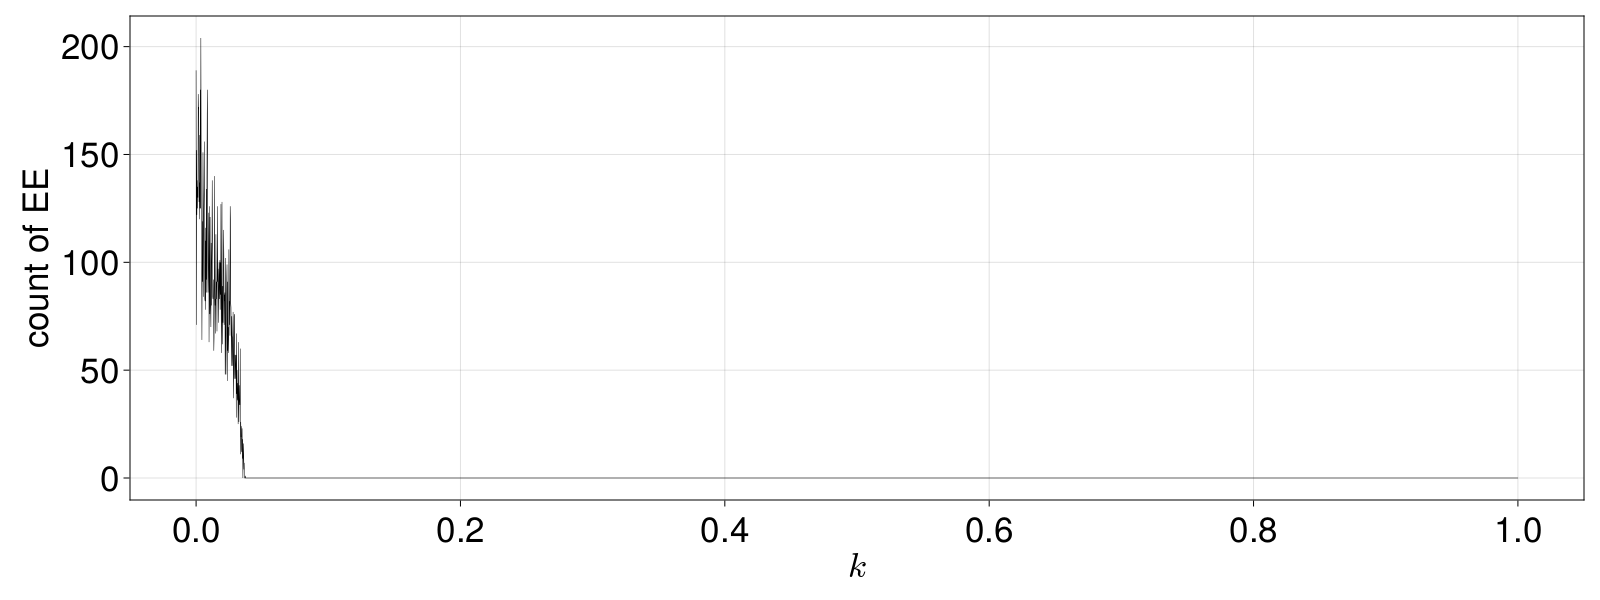

In [70]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = "count of EE")


limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
ax1.xticks = limits

lines!(ax, k_space, EVA_array, color = "black", linewidth = 0.5)

f

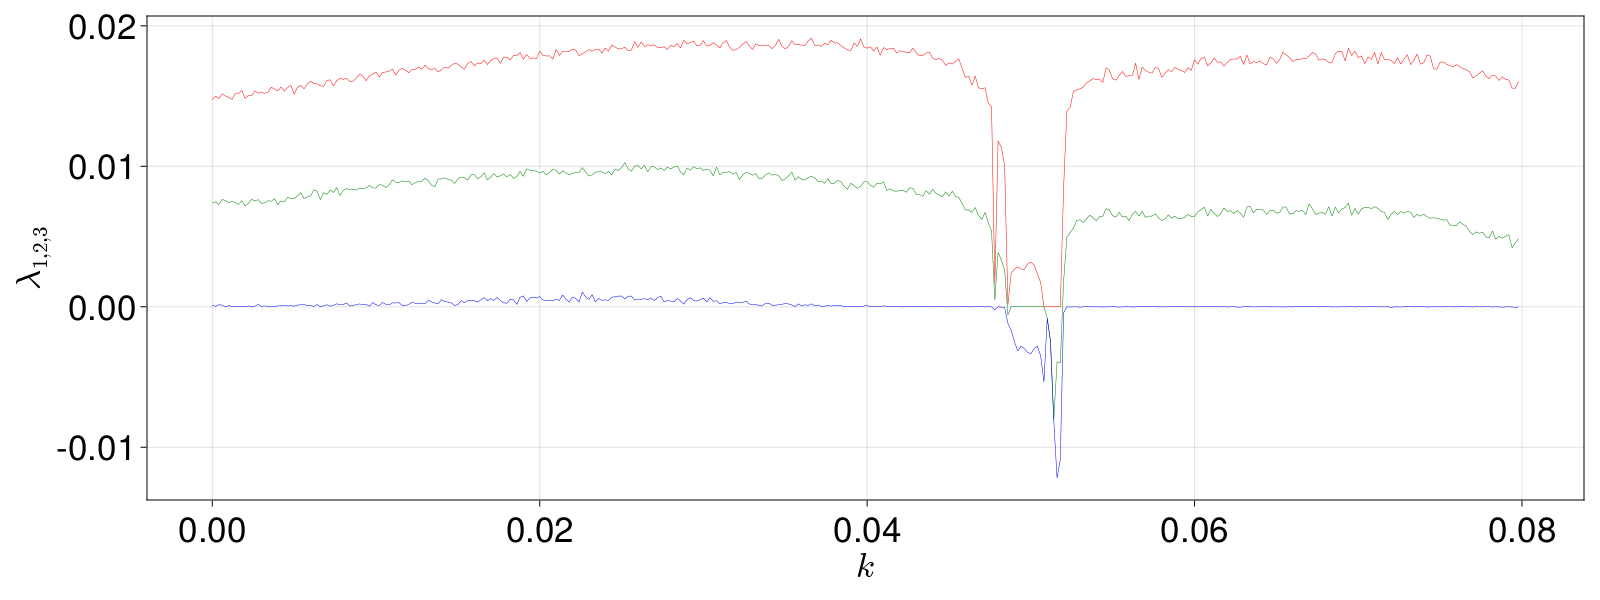

In [71]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")

lines!(ax, k_space[1:400], spectrum_array[1, 1:400], color = "red", linewidth = 0.5)
lines!(ax, k_space[1:400], spectrum_array[2, 1:400], color = "green", linewidth = 0.5)
lines!(ax, k_space[1:400], spectrum_array[3, 1:400], color = "blue", linewidth = 0.5)

f

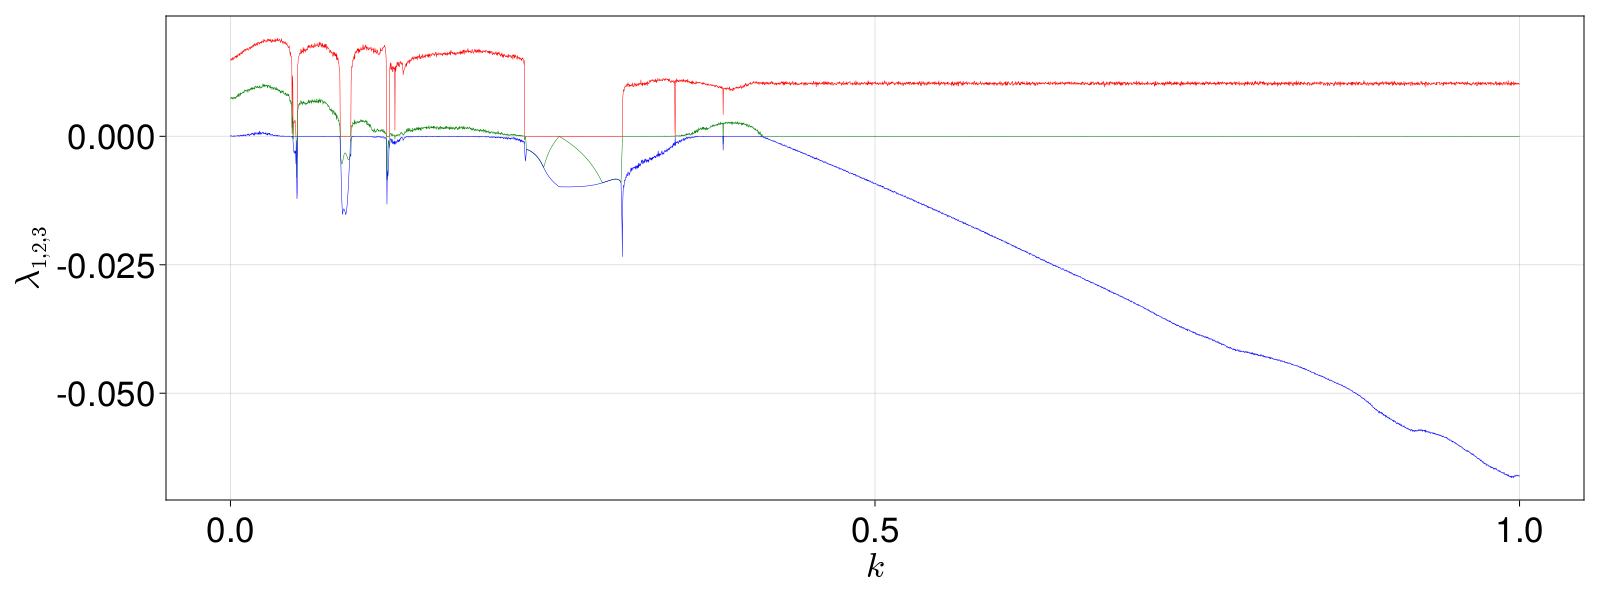

In [72]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")

lines!(ax, k_space[1:end], spectrum_array[1, 1:end], color = "red", linewidth = 0.5)
lines!(ax, k_space[1:end], spectrum_array[2, 1:end], color = "green", linewidth = 0.5)
lines!(ax, k_space[1:end], spectrum_array[3, 1:end], color = "blue", linewidth = 0.5)

f